In [ ]:
# !conda install -c pytorch torchvision
# !pip install skillsnetwork tqdm
# !pip install skillsnetwork
# !pip install datasets

In [36]:
from datasets import *
from datetime import datetime
#from skillsnetwork import cvstudio

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from matplotlib.pyplot import imshow
from tqdm import tqdm
import torch
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import lr_scheduler
from torchvision import transforms
import torch.nn as nn
import torch.cuda
torch.manual_seed(0)

import time
import copy

In [58]:
cifar_dataset = load_dataset("cifar10")

Using the latest cached version of the module from C:\Users\avida\.cache\huggingface\modules\datasets_modules\datasets\cifar10\447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4 (last modified on Sun Sep 10 20:34:36 2023) since it couldn't be found locally at cifar10., or remotely on the Hugging Face Hub.


In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device type is", device)

the device type is cuda:0


In [39]:
def plot_cost_accuracy(cost, acc) :
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(cost, color=color)
    ax1.set_xlabel('Iteration', color=color)
    ax1.set_ylabel('Cost', color=color)
    ax1.tick_params(axis='y', color=color)
    
    ax2 = ax1.twinx()
    color='color:green'
    ax2.plot(acc, color=color)
    ax2.set_xlabel('Iteration', color=color)
    ax2.set_ylabel('Accuracy', color=color)
    ax2.tick_params(axis='y', color=color)
    
    fig.tight_layout()
    plt.show()

In [62]:
train_set = cifar_dataset["train"]
validation_set = cifar_dataset["test"]

In [41]:
print(train_set)

Dataset({
    features: ['img', 'label'],
    num_rows: 50000
})


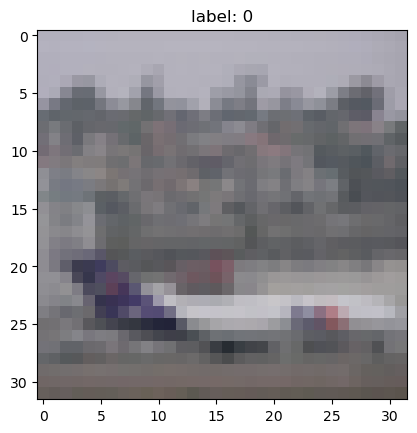

In [60]:
plt.title('label: ' + str(train_set[0]['label']))
imshow(train_set[0]['img'])

In [43]:
n_epochs = 10
batch_size=32
lr=0.00001
momentum=0.9
base_lr=0.001
max_lr=0.01

In [85]:
def train_model(model, train_loader, validation_loader, criterion, optimizer, n_epochs, print_=True) :
    loss_list=[]
    accuracy_list=[]
    correct=0
    
    n_tests = len(validation_set)
    accuracy_best=0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in tqdm(range(n_epochs)) :
        loss_sublist=[]
        
        for img, label in train_loader :
            img, label = np.array(img).to(device), label.to(device)
            model.train()
            
            z = model(img)
            loss = criterion(z, label)
            loss_sublist.append(loss.data.item())
            loss.backward()
            optimizer.step()
            
            optimizer.zero_grad()
            
        print("epoch {1} done".format(epoch))
        
        scheduler.step()
        loss_list.append(np.mean(loss_sublist))
        correct = 0
        
        for img, label in validation_loader :
            img_test, label_test = np.array(img_test).to(device), label_test.to(device)
            model.eval()
            
            z=model(img)
            _, yhat = torch.max(z.data, 1)
            
            correct += (yhat == ytest).sum().item()
        accuracy = correct / n_tests
        accuracy_list.append(accuracy)
        
        if accuracy > accuracy_best :
            accuracy_best=accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            
        if print_ :
            print("The learning rate is", optimizer.param_groups[0]['lr'])
            print("The validation cost for epoch " + str(epoch + 1) + ": " +str(np.mean(loss_sublist)))
            print("The validation accuracy for epoch" + str(epoch + 1) + ": " + str(accuracy))
            
    model.load_state_dict(best_model_wts)
    
    return accuracy_list, loss_list, model

In [45]:
model = models.resnet18(pretrained=True)
for param in model.parameters() :
    param.requires_grad=False

C:\Users\avida\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\avida\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
#We want the model to classify 10 different classes, 
#and the last hidden layer has 512 neurons.
model.fc = nn.Linear(512, 10)

In [47]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [48]:
criterion = nn.CrossEntropyLoss()

In [ ]:


means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

convert_tensor = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=means,
                                                std=stds)
                       ])

#train_set = train_set.map(lambda e : {'img' : convert_tensor(e['img']).unsqueeze(0), 'label' : e['label']})
#validation_set = validation_set.map(lambda e : {'img' : convert_tensor(e['img']).unsqueeze(0), 'label' : e['label']})
# validation_set = validation_set.map(lambda e : {'img' : convert_tensor(e['img']).unsqueeze(0), 'label' : e['label']})

#train_list = [(e['img'], e['label']) for e in train_set]
#val_list = [(e['img'], e['label']) for e in validation_set]

tr_set = pd.DataFrame({
    "img" : train_set["img"],
    "label" : train_set["label"]
})

val_set = pd.DataFrame({
    "img" : validation_set["img"],
    "label" : validation_set["label"]
})

train_loader = DataLoader(dataset=tr_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=1)

# next(iter(train_loader))['img']

In [92]:
for img, lbl in train_loader :
    print(img, lbl) 
    break

img label


In [80]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [81]:
scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=base_lr, max_lr=max_lr, step_size_up=5, mode="triangular2")

In [86]:
start_datetime = datetime.now()
start_time = time.time()

acc_list, loss_list, model = train_model(model, train_loader, val_loader, criterion, optimizer, n_epochs=n_epochs)

end_datetime = datetime.now()
current_time = time.time()
print("time elapsed", current_time - start_time)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\avida\AppData\Local\Temp\ipykernel_15660\1860368058.py:14: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  img, label = np.array(img).to(device), label.to(device)
  0%|                                                                                           | 0/10 [00:00<?, ?it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 4 dimensions. The detected shape was (1, 3, 32, 32) + inhomogeneous part.

TypeError: pic should be PIL Image or ndarray. Got <class 'list'>

range(0, 50000)
